# Problem Set #2
#### MACS 30100, Dr. Evans

#### Mengchen Shi
#### Jan 21th, 2018

## Part 1

### (a)

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

%matplotlib notebook

incomes = np.loadtxt('incomes.txt', delimiter=',', unpack=True)

<IPython.core.display.Javascript object>


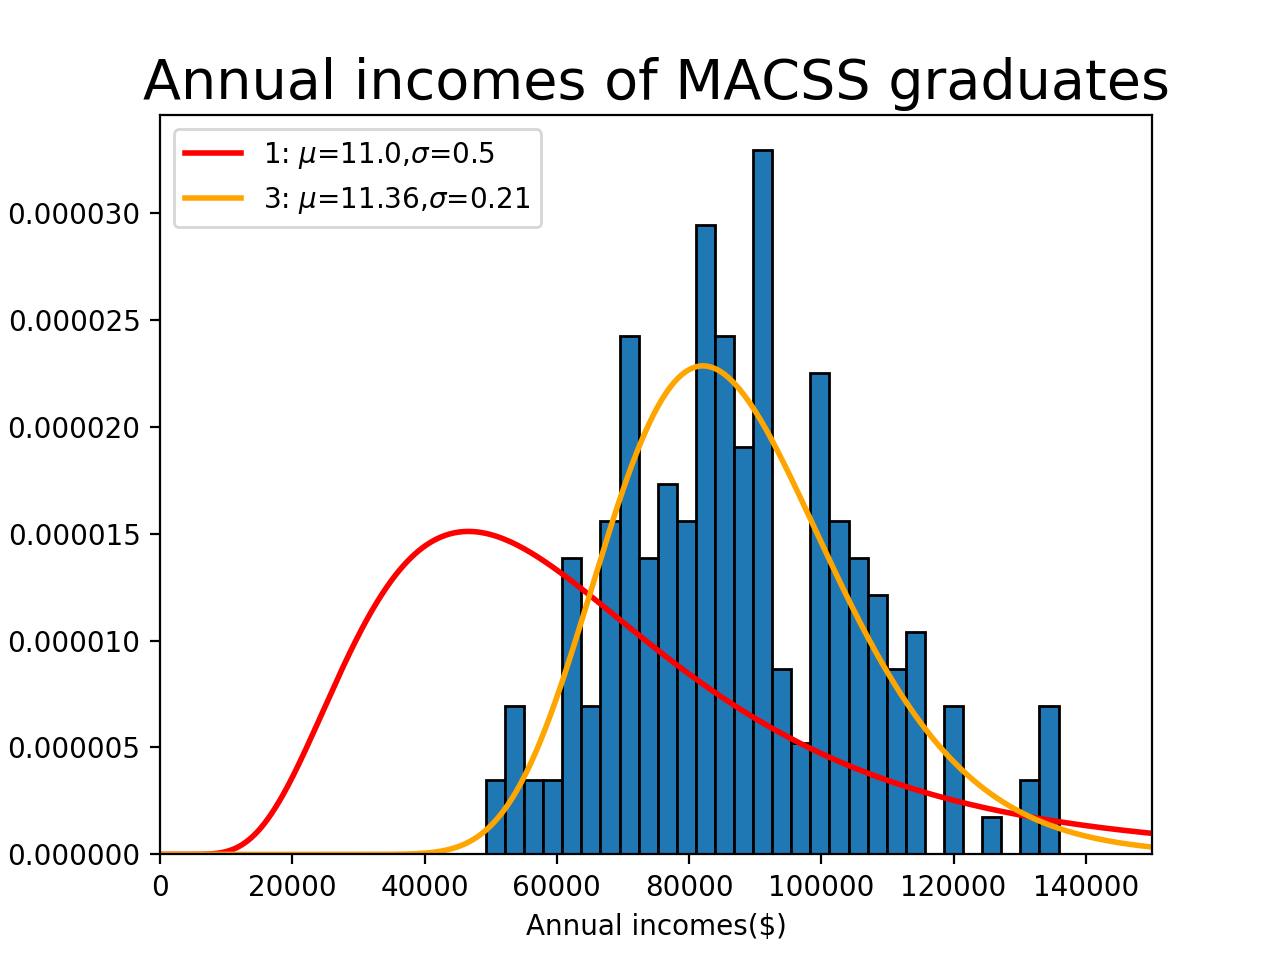

(0, 150000)

In [2]:
count, bins, ignored = plt.hist(incomes, 30,edgecolor='black', normed=True)
plt.title('Annual incomes of MACSS graduates', fontsize=20)
plt.xlabel(r'Annual incomes(\$)')
plt.ylabel('Percent of observations')
plt.xlim([0, 150000])  # This gives the xmin and xmax to be plotted"

### (b)

In [3]:
# Define function that generates values of a potentially trucated normal
# probability density function (PDF)
def norm_pdf(xvals, mu, sigma):
    '''
    ---------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. This function does the samething as 
    sts.norm.pdf(xvals, loc=mu, scale=sigma).
    ---------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally 
             distributed random variable

    RETURNS: pdf_vals
    ---------------------------------------------------------------------
    '''
            
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals



dist_pts = np.linspace(0.01, 150000, 1000)
mu_1 = 11.0
sig_1 = 0.5
pdf_lnvals = norm_pdf(dist_pts, mu_1, sig_1)
plt.plot(dist_pts, pdf_lnvals,
         linewidth=2, color='r', label='1: $\mu$=11.0,$\sigma$=0.5')
plt.legend(loc='upper left')


In [4]:
# Define log likelihood function for the normal distribution
def log_lik_norm(xvals, mu, sigma):
    pdf_vals = norm_pdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood: ', log_lik_norm(incomes, mu_1, sig_1))

Log-likelihood:  -2385.85699781


### (c)

In [5]:
def crit(params, args):
    
    '''
    ----------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    ----------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    args   = xvals

    RETURNS: neg_log_lik_val
    ----------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals = args
    log_lik_val = log_lik_norm(xvals, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val


In [6]:
#ML estimates for μ and σ
import scipy.optimize as opt

mu_init = 11.0 
sig_init = 0.5 
params_init = np.array([mu_init, sig_init])
mle_args = (incomes)
results = opt.minimize(crit, params_init, args=(mle_args), bounds=((0.1, None),(0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.3590243967  sig_MLE= 0.208178530156


In [7]:
# plot MLE against histrogram and pdf in part b

plt.plot(dist_pts, norm_pdf(dist_pts, mu_MLE, sig_MLE),
         linewidth=2, color='orange', label='3: $\mu$=11.36,$\sigma$=0.21')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [8]:
print('MLE log-likelihood: ', log_lik_norm(incomes, mu_MLE, sig_MLE))

MLE log-likelihood:  -2241.71930137


In [9]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])

vcv_mle = results.hess_inv.todense() * OffDiagNeg
print(vcv_mle)

[[  2.52831353e-04  -2.76208826e-05]
 [ -2.76208826e-05   1.30457089e-04]]


### (d)

In [10]:
log_lik_h0 = log_lik_norm(incomes, 11.0, 0.5)
log_lik_mle = log_lik_norm(incomes, mu_MLE, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)
print('The probability that mu is 11 is 0.0, and the probability that sigma is 0.5 is 0.0.')

chi squared of H0 with 2 degrees of freedom p-value =  0.0
The probability that mu is 11 is 0.0, and the probability that sigma is 0.5 is 0.0.


### (e)

In [11]:
from scipy.integrate import quad
prob_100000_plus = quad(norm_pdf, 100000, 150000, args=(mu_MLE, sig_MLE))
prob_75000_minus = quad(norm_pdf, 0, 75000, args=(mu_MLE, sig_MLE))
print('The probability that I will earn more than $100,000 is ', prob_100000_plus[0])
print('The probability that I will earn less than $75,000 is ', prob_75000_minus[0])

The probability that I will earn more than $100,000 is  0.2262648386237647
The probability that I will earn less than $75,000 is  0.2602332979233366


## Part 2

### (a)

In [12]:
import numpy as np
import scipy.stats as sts
sick,age,children,avgtemp_winter = np.loadtxt('sick.txt', delimiter=',', skiprows=1, unpack=True)

In [13]:
def sum_errors(param, args):
    '''
    ---------------------------------------------------------------------
    This function computes the sum of squares of errors.
    ---------------------------------------------------------------------
    INPUTS:
    params = (5,) vector, ([b0, b1, b2, b3, sigma])
    args   = xvals
    
    RETURNS: errors.sum()
    ---------------------------------------------------------------------
    '''
    
    b0,b1,b2,b3,sigma2 = param
    sick,age,children,avgtemp_winter = args
    errors = (sick - b0 - b1*age - b2*children - b3 *avgtemp_winter) ** 2
    return errors.sum()

def crit_err(param, args):
    '''
    ---------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    ---------------------------------------------------------------------
    INPUTS:
    params = (5,) vector, ([b0, b1, b2, b3, sigma])
    args   = xvals
    
    RETURNS: -log_lik_val
    ---------------------------------------------------------------------
    '''
    sigma2 = param[-1]
    sum_err = sum_errors(param, args)
    n = len(sick)
    log_lik_err = -n/2*np.log(2*np.pi) - n*np.log(np.sqrt(sigma2)) - sum_err/(2*sigma2)
    
    return -log_lik_err


In [14]:
import scipy.optimize as opt

param_init = (1, 0, 0, 0, 0.01)
mle_args = np.array((sick,age,children,avgtemp_winter))
results = opt.minimize(crit_err, param_init, args=(mle_args), method = 'L-BFGS-B',bounds=((None, None),(None, None), (None, None), (None, None), (1e-10, None)))
b0, b1, b2, b3, sigma2 = results.x

Hinv = results.hess_inv.todense()
OffDiagNeg = -np.ones(Hinv.shape) + np.eye(Hinv.shape[0])* 2
#OffDiagNeg = np.eye(5)*2 - 1
vcv_mle = results.hess_inv.todense() * OffDiagNeg

In [15]:
print('MLE estimates for b1, b2, b3, sigma2 are: \n', results.x)
print('MLE log-likelihood: \n', -results.fun)
print('MLE estimated variance covariance matrix: \n', vcv_mle)

MLE estimates for b1, b2, b3, sigma2 are: 
 [  2.51644129e-01   1.29334454e-02   4.00501328e-01  -9.99168100e-03
   9.10133490e-06]
MLE log-likelihood: 
 876.865049961
MLE estimated variance covariance matrix: 
 [[  1.68136352e+03  -3.14816213e+02   3.85583455e+03   1.89511890e+02
   -7.23837506e-01]
 [ -3.14816213e+02   1.34022669e+02   1.33117236e+03   8.14738191e+01
   -2.90177565e-01]
 [  3.85583455e+03   1.33117236e+03   1.37861555e+04  -8.07781197e+02
    2.91496337e+00]
 [  1.89511890e+02   8.14738191e+01  -8.07781197e+02   4.95327363e+01
    1.76314498e-01]
 [ -7.23837506e-01  -2.90177565e-01   2.91496337e+00   1.76314498e-01
    6.30232667e-04]]


### (b)

In [16]:
log_lik_h0 = -crit_err((1.0, 0, 0, 0, 0.01), (mle_args))
log_lik_mle = -crit_err((b0, b1, b2, b3, sigma2), (mle_args))
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)
print('The hypthesis is rejected.')

chi squared of H0 with 5 degrees of freedom p-value =  0.0
The hypthesis is rejected.
